In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

2023-03-27 18:45:44.721709: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-03-27 18:45:44.781998: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-03-27 18:45:44.783385: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-27 18:45:45.991614: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/bradwaj/.local/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:

tsv_data = pd.read_csv("./train.tsv", sep="\t")
tsv_data.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [3]:
tsv_data.drop_duplicates(subset="SentenceId", keep="first", inplace=True)
tsv_data.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
63,64,2,"This quiet , introspective and entertaining in...",4
81,82,3,"Even fans of Ismail Merchant 's work , I suspe...",1
116,117,4,A positively thrilling combination of ethnogra...,3
156,157,5,Aggressive self-glorification and a manipulati...,1


In [4]:
tsv_data.shape

(8529, 4)

In [5]:
seqlen = tsv_data["Phrase"].apply(lambda x: len(x.split()))
print(seqlen.shape)

(8529,)


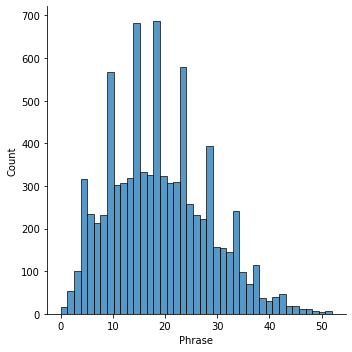

<Figure size 2160x1080 with 0 Axes>

In [6]:
sns.displot(seqlen)

sns.set_style("darkgrid")
plt.figure(figsize=(30, 15))
plt.show()

In [7]:
SEQ_LEN = 50

In [8]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')

In [9]:
Xids = np.zeros((len(tsv_data), SEQ_LEN))
Xmask = np.zeros((len(tsv_data), SEQ_LEN))

Xids.shape, Xmask.shape

((8529, 50), (8529, 50))

In [10]:
for i, sequence in enumerate(tsv_data["Phrase"]):
    tokens = tokenizer.encode_plus(sequence, max_length=SEQ_LEN, 
                               truncation=True, padding="max_length",
                               add_special_tokens=True, return_token_type_ids=False,
                               return_attention_mask=True, return_tensors="tf"
                              )
    Xids[i, :], Xmask[i, :] = tokens["input_ids"], tokens["attention_mask"]

In [11]:
Xids[0]

array([  101.,   138.,  1326.,  1104., 13936., 25265., 16913., 15107.,
        1103.,  8050.,  2553.,  1115.,  1184.,  1110.,  1363.,  1111.,
        1103., 20398.,  1110.,  1145.,  1363.,  1111.,  1103.,   176.,
        9900.,   117.,  1199.,  1104.,  1134.,  5411.,  1821., 14225.,
        1133.,  3839.,  1104.,  1134.,  7919.,  1106.,  1277.,  1104.,
         170.,  1642.,   119.,   102.,     0.,     0.,     0.,     0.,
           0.,     0.])

In [12]:
Xmask[0]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.])

In [13]:
tsv_data["Sentiment"].value_counts()

3    2321
1    2200
2    1655
4    1281
0    1072
Name: Sentiment, dtype: int64

In [14]:
arr = tsv_data["Sentiment"].values
labels = np.zeros((arr.size, arr.max()+1))

labels

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [15]:
labels[np.arange(arr.size), arr] = 1
labels

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.]])

In [16]:
with open("./Dataset.npz", "wb") as f:
    np.savez(f, Xids = Xids, Xmask = Xmask, labels = labels)

In [17]:
del Xids, Xmask, labels, tsv_data

In [18]:
with open("./Dataset.npz", "rb") as f:
    data = np.load(f)
    
    Xids = data["Xids"]
    Xmask = data["Xmask"]
    labels = data["labels"]

In [19]:
Xids.shape, Xmask.shape, labels.shape

((8529, 50), (8529, 50), (8529, 5))

In [20]:
tf.config.experimental.list_logical_devices("GPU")

[]

In [21]:
dataset = tf.data.Dataset.from_tensor_slices((Xids, Xmask, labels))

In [22]:
for i in dataset.take(1):
    print(i)

(<tf.Tensor: shape=(50,), dtype=float64, numpy=
array([  101.,   138.,  1326.,  1104., 13936., 25265., 16913., 15107.,
        1103.,  8050.,  2553.,  1115.,  1184.,  1110.,  1363.,  1111.,
        1103., 20398.,  1110.,  1145.,  1363.,  1111.,  1103.,   176.,
        9900.,   117.,  1199.,  1104.,  1134.,  5411.,  1821., 14225.,
        1133.,  3839.,  1104.,  1134.,  7919.,  1106.,  1277.,  1104.,
         170.,  1642.,   119.,   102.,     0.,     0.,     0.,     0.,
           0.,     0.])>, <tf.Tensor: shape=(50,), dtype=float64, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.])>, <tf.Tensor: shape=(5,), dtype=float64, numpy=array([0., 1., 0., 0., 0.])>)


2023-03-27 18:45:52.811296: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype double and shape [8529,5]
	 [[{{node Placeholder/_2}}]]


In [23]:
def map_func(input_ids, masks, labels):
    return {"input_ids": input_ids, "attention_mask": masks}, labels

In [24]:
dataset = dataset.map(map_func)

for i in dataset.take(1):
    print(i)

({'input_ids': <tf.Tensor: shape=(50,), dtype=float64, numpy=
array([  101.,   138.,  1326.,  1104., 13936., 25265., 16913., 15107.,
        1103.,  8050.,  2553.,  1115.,  1184.,  1110.,  1363.,  1111.,
        1103., 20398.,  1110.,  1145.,  1363.,  1111.,  1103.,   176.,
        9900.,   117.,  1199.,  1104.,  1134.,  5411.,  1821., 14225.,
        1133.,  3839.,  1104.,  1134.,  7919.,  1106.,  1277.,  1104.,
         170.,  1642.,   119.,   102.,     0.,     0.,     0.,     0.,
           0.,     0.])>, 'attention_mask': <tf.Tensor: shape=(50,), dtype=float64, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.])>}, <tf.Tensor: shape=(5,), dtype=float64, numpy=array([0., 1., 0., 0., 0.])>)


2023-03-27 18:45:52.880629: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype double and shape [8529,5]
	 [[{{node Placeholder/_2}}]]


In [25]:
dataset = dataset.shuffle(1000000).batch(32)

In [26]:
DS_LEN = len(dataset)

In [27]:
SPLIT = 0.9

train_data = dataset.take(round(DS_LEN * SPLIT))
val_data = dataset.skip(round(DS_LEN * SPLIT))

del dataset

In [33]:
from transformers import TFAutoModel

bert = TFAutoModel.from_pretrained("bert-base-cased")

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [34]:
input_ids = tf.keras.layers.Input(shape=(SEQ_LEN, ), name="input_ids", dtype="int32")
mask = tf.keras.layers.Input(shape=(SEQ_LEN, ), name="attention_mask", dtype="int32")

embeddings = bert(input_ids, attention_mask=mask)[0]

X = tf.keras.layers.GlobalMaxPool1D()(embeddings)
X = tf.keras.layers.BatchNormalization()(X)
X = tf.keras.layers.Dense(64, activation="relu")(X)
X = tf.keras.layers.Dense(128, activation="relu")(X)
X = tf.keras.layers.Dropout(0.1)(X)
X = tf.keras.layers.Dense(64, activation="relu")(X)
X = tf.keras.layers.Dense(32, activation="relu")(X)

y = tf.keras.layers.Dense(5, activation="softmax",  name="outputs")(X)

model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)

model.layers[2].trainable = False

In [35]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 50)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 50)]         0           []                               
                                                                                                  
 tf_bert_model_1 (TFBertModel)  TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 50,                                          

In [38]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=8),
            tf.keras.callbacks.ModelCheckpoint("./dense_transformer_model.h5",verbose= 1 ,save_best_only=True)]

optimizer = tf.keras.optimizers.Adam(0.001)
loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy("accuracy")

model.compile(optimizer=optimizer, loss=loss, metrics=[acc])

In [39]:
history = model.fit(train_data, 
                   validation_data=val_data,
                   epochs=200,
                   callbacks=callbacks
                   )

Epoch 1/200
240/240 [==============================] - ETA: 0s - loss: 1.3265 - accuracy: 0.4201
Epoch 1: val_loss improved from inf to 1.21788, saving model to ./dense_transformer_model.h5
240/240 [==============================] - 533s 2s/step - loss: 1.3265 - accuracy: 0.4201 - val_loss: 1.2179 - val_accuracy: 0.4452
Epoch 2/200
240/240 [==============================] - ETA: 0s - loss: 1.2727 - accuracy: 0.4514
Epoch 2: val_loss improved from 1.21788 to 1.15878, saving model to ./dense_transformer_model.h5
240/240 [==============================] - 506s 2s/step - loss: 1.2727 - accuracy: 0.4514 - val_loss: 1.1588 - val_accuracy: 0.5077
Epoch 3/200
240/240 [==============================] - ETA: 0s - loss: 1.2525 - accuracy: 0.4531
Epoch 3: val_loss improved from 1.15878 to 1.12645, saving model to ./dense_transformer_model.h5
240/240 [==============================] - 510s 2s/step - loss: 1.2525 - accuracy: 0.4531 - val_loss: 1.1265 - val_accuracy: 0.5241
Epoch 4/200
240/240 [=====

240/240 [==============================] - ETA: 0s - loss: 0.8918 - accuracy: 0.6379
Epoch 27: val_loss improved from 0.57503 to 0.56868, saving model to ./dense_transformer_model.h5
240/240 [==============================] - 470s 2s/step - loss: 0.8918 - accuracy: 0.6379 - val_loss: 0.5687 - val_accuracy: 0.7856
Epoch 28/200
240/240 [==============================] - ETA: 0s - loss: 0.8908 - accuracy: 0.6430
Epoch 28: val_loss did not improve from 0.56868
240/240 [==============================] - 474s 2s/step - loss: 0.8908 - accuracy: 0.6430 - val_loss: 0.5696 - val_accuracy: 0.8080
Epoch 29/200
240/240 [==============================] - ETA: 0s - loss: 0.8797 - accuracy: 0.6477
Epoch 29: val_loss improved from 0.56868 to 0.51558, saving model to ./dense_transformer_model.h5
240/240 [==============================] - 487s 2s/step - loss: 0.8797 - accuracy: 0.6477 - val_loss: 0.5156 - val_accuracy: 0.8304
Epoch 30/200
240/240 [==============================] - ETA: 0s - loss: 0.8824 

240/240 [==============================] - ETA: 0s - loss: 0.7463 - accuracy: 0.7017
Epoch 54: val_loss improved from 0.34336 to 0.33687, saving model to ./dense_transformer_model.h5
240/240 [==============================] - 468s 2s/step - loss: 0.7463 - accuracy: 0.7017 - val_loss: 0.3369 - val_accuracy: 0.9034
Epoch 55/200
240/240 [==============================] - ETA: 0s - loss: 0.7508 - accuracy: 0.6999
Epoch 55: val_loss improved from 0.33687 to 0.33456, saving model to ./dense_transformer_model.h5
240/240 [==============================] - 477s 2s/step - loss: 0.7508 - accuracy: 0.6999 - val_loss: 0.3346 - val_accuracy: 0.9093
Epoch 56/200
240/240 [==============================] - ETA: 0s - loss: 0.7348 - accuracy: 0.7069
Epoch 56: val_loss improved from 0.33456 to 0.32048, saving model to ./dense_transformer_model.h5
240/240 [==============================] - 469s 2s/step - loss: 0.7348 - accuracy: 0.7069 - val_loss: 0.3205 - val_accuracy: 0.9081
Epoch 57/200
240/240 [=======

240/240 [==============================] - ETA: 0s - loss: 0.6746 - accuracy: 0.7419
Epoch 81: val_loss did not improve from 0.21898
240/240 [==============================] - 467s 2s/step - loss: 0.6746 - accuracy: 0.7419 - val_loss: 0.2432 - val_accuracy: 0.9317
Epoch 82/200
240/240 [==============================] - ETA: 0s - loss: 0.6678 - accuracy: 0.7348
Epoch 82: val_loss did not improve from 0.21898
240/240 [==============================] - 465s 2s/step - loss: 0.6678 - accuracy: 0.7348 - val_loss: 0.2306 - val_accuracy: 0.9364
Epoch 83/200
240/240 [==============================] - ETA: 0s - loss: 0.6769 - accuracy: 0.7336
Epoch 83: val_loss did not improve from 0.21898
240/240 [==============================] - 471s 2s/step - loss: 0.6769 - accuracy: 0.7336 - val_loss: 0.2263 - val_accuracy: 0.9435
Epoch 84/200
240/240 [==============================] - ETA: 0s - loss: 0.6751 - accuracy: 0.7365
Epoch 84: val_loss did not improve from 0.21898
240/240 [========================

240/240 [==============================] - 472s 2s/step - loss: 0.6418 - accuracy: 0.7510 - val_loss: 0.1890 - val_accuracy: 0.9670
Epoch 110/200
240/240 [==============================] - ETA: 0s - loss: 0.6233 - accuracy: 0.7625
Epoch 110: val_loss did not improve from 0.16731
240/240 [==============================] - 467s 2s/step - loss: 0.6233 - accuracy: 0.7625 - val_loss: 0.1808 - val_accuracy: 0.9670
Epoch 111/200
240/240 [==============================] - ETA: 0s - loss: 0.6321 - accuracy: 0.7564
Epoch 111: val_loss did not improve from 0.16731
240/240 [==============================] - 469s 2s/step - loss: 0.6321 - accuracy: 0.7564 - val_loss: 0.2038 - val_accuracy: 0.9388


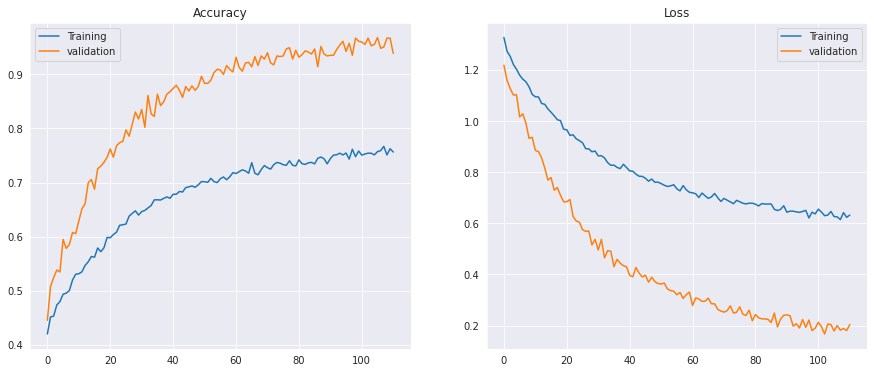

In [40]:
hist = history
plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
plt.plot(hist.epoch,hist.history['accuracy'],label = 'Training')
plt.plot(hist.epoch,hist.history['val_accuracy'],label = 'validation')

plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(hist.epoch,hist.history['loss'],label = 'Training')
plt.plot(hist.epoch,hist.history['val_loss'],label = 'validation')

plt.title("Loss")
plt.legend()
plt.show()

In [41]:
def map_to_input(sen:str, seq_len:int):
    tokens = tokenizer.encode_plus(sen, max_length=seq_len, 
                               truncation=True, padding="max_length",
                               add_special_tokens=True, return_token_type_ids=False,
                               return_attention_mask=True, return_tensors="tf"
                              )
    
    return tokens

### TEST

```
The sentiment labels are:

0 - Sad
1 - Sad
2 - neutral
3 - Happy
4 - Happy
```


In [42]:
from transformers import TFBertModel

# Define the custom objects dictionary with the TFBertModel layer
custom_objects = {'TFBertModel': TFBertModel}

# Load the model and pass the custom objects dictionary
model = tf.keras.models.load_model('./dense_transformer_model.h5', custom_objects=custom_objects)

In [43]:
classes = {
    0: "Sad",
    1: "Sad",
    2: "Neutral",
    3: "Happy",
    4: "Happy"
}

In [44]:
test_data = pd.read_csv("./test.tsv", sep="\t")
test_data.drop_duplicates(subset="SentenceId", keep="first", inplace=True)
test_data.head()

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
15,156076,8546,Kidman is really the only thing that 's worth ...
93,156154,8547,Once you get into its rhythm ... the movie bec...
117,156178,8548,I kept wishing I was watching a documentary ab...
158,156219,8549,"Kinnear does n't aim for our sympathy , but ra..."


In [45]:
final_out = {}

for i in tqdm(range(100)):
    to_test = test_data["Phrase"].iloc[i]
    print(to_test)

    test_input = map_to_input(to_test, SEQ_LEN)
    input_ids = test_input["input_ids"]
    mask = test_input["attention_mask"]
    
    pred = model.predict([input_ids, mask], verbose=0)
#     print(f"The output class is: {classes[np.argmax(pred[0])]}")
    final_out[to_test] = classes[np.argmax(pred[0])]

  0%|                                                                                           | 0/100 [00:00<?, ?it/s]

An intermittently pleasing but mostly routine effort .


  1%|▊                                                                                  | 1/100 [00:10<17:24, 10.56s/it]

Kidman is really the only thing that 's worth watching in Birthday Girl , a film by the stage-trained Jez Butterworth -LRB- Mojo -RRB- that serves as yet another example of the sad decline of British comedies in the post-Full Monty world .


  3%|██▍                                                                                | 3/100 [00:10<04:04,  2.52s/it]

Once you get into its rhythm ... the movie becomes a heady experience .
I kept wishing I was watching a documentary about the wartime Navajos and what they accomplished instead of all this specious Hollywood hoo-ha .


  4%|███▎                                                                               | 4/100 [00:11<02:33,  1.59s/it]

Kinnear does n't aim for our sympathy , but rather delivers a performance of striking skill and depth .


  6%|████▉                                                                              | 6/100 [00:11<01:13,  1.28it/s]

All ends well , sort of , but the frenzied comic moments never click .
It 's a hoot and a half , and a great way for the American people to see what a candidate is like when he 's not giving the same 15-cent stump speech .


  8%|██████▋                                                                            | 8/100 [00:11<00:41,  2.20it/s]

The weight of the piece , the unerring professionalism of the chilly production , and the fascination embedded in the lurid topic prove recommendation enough .
The film contains no good jokes , no good scenes , barely a moment when Carvey 's Saturday Night Live-honed mimicry rises above the level of embarrassment .


 10%|████████▏                                                                         | 10/100 [00:12<00:28,  3.21it/s]

An offbeat , sometimes gross and surprisingly appealing animated film about the true meaning of the holidays .
It suggests the wide-ranging effects of media manipulation , from the kind of reporting that is done by the supposedly liberal media ... to the intimate and ultimately tragic heartache of maverick individuals like Hatfield and Hicks .


 12%|█████████▊                                                                        | 12/100 [00:12<00:20,  4.25it/s]

As Tweedy talks about canning his stockbroker and repairing his pool , you yearn for a few airborne TV sets or nude groupies on the nod to liven things up .
For all its failed connections , Divine Secrets of the Ya-Ya Sisterhood is nurturing , in a gauzy , dithering way .


 14%|███████████▍                                                                      | 14/100 [00:12<00:17,  5.01it/s]

It would be hard to think of a recent movie that has worked this hard to achieve this little fun .
The story and structure are well-honed .


 16%|█████████████                                                                     | 16/100 [00:13<00:15,  5.32it/s]

Chilling but uncommercial look into the mind of Jeffrey Dahmer , serial killer .
... the movie is just a plain old monster .


 18%|██████████████▊                                                                   | 18/100 [00:13<00:14,  5.47it/s]

This film 's relationship to actual tension is the same as what Christmas-tree flocking in a spray can is to actual snow : a poor -- if durable -- imitation .
A depressing confirmation of everything those of us who do n't object to the description `` unelected '' have suspected all along : George W. Bush is an incurious , uncharismatic , overgrown frat boy with a mean streak a mile wide .


 20%|████████████████▍                                                                 | 20/100 [00:13<00:13,  5.83it/s]

You do n't have to know about music to appreciate the film 's easygoing blend of comedy and romance .
However , it lacks grandeur and that epic quality often associated with Stevenson 's tale as well as with earlier Disney efforts .


 22%|██████████████████                                                                | 22/100 [00:14<00:13,  5.97it/s]

Although occasionally static to the point of resembling a stage play , the film delivers a solid mixture of sweetness and laughs .
An occasionally funny , but overall limp , fish-out-of-water story .


 24%|███████████████████▋                                                              | 24/100 [00:14<00:12,  6.11it/s]

a nightmare date with a half-formed wit done a great disservice by a lack of critical distance and a sad trust in liberal arts college bumper sticker platitudes .
A fitfully amusing romp that , if nothing else , will appeal to fans of Malcolm in the Middle and its pubescent star , Frankie Muniz .


 26%|█████████████████████▎                                                            | 26/100 [00:14<00:12,  5.97it/s]

If I Spy were funny -LRB- enough -RRB- or exciting -LRB- enough -RRB- then it would be fairly simple to forgive the financial extortion it 's trying to reap from the moviegoing public .
Borrows from so many literary and cinematic sources that this future world feels absolutely deja vu .


 28%|██████████████████████▉                                                           | 28/100 [00:15<00:11,  6.05it/s]

Despite its title , Amy 's Orgasm is not a porno , though it is as tedious as one .
That dogged good will of the parents and ` vain ' Jia 's defoliation of ego , make the film touching despite some doldrums .


 30%|████████████████████████▌                                                         | 30/100 [00:15<00:11,  5.90it/s]

Imagine a really bad community theater production of West Side Story without the songs .
It 's an old story , but a lively script , sharp acting and partially animated interludes make Just a Kiss seem minty fresh .


 32%|██████████████████████████▏                                                       | 32/100 [00:15<00:11,  6.12it/s]

The most hopelessly monotonous film of the year , noteworthy only for the gimmick of being filmed as a single unbroken 87-minute take .
Prancing his way through the tailor-made part of a male hooker approaching the end of his vitality , Jagger obviously relishes every self-mocking moment .


 34%|███████████████████████████▉                                                      | 34/100 [00:16<00:10,  6.22it/s]

A distant , even sterile , yet compulsively watchable look at the sordid life of Hogan 's Heroes star Bob Crane .
Creepy but ultimately unsatisfying thriller .


 36%|█████████████████████████████▌                                                    | 36/100 [00:16<00:10,  6.22it/s]

I just did n't care as much for the story .
Extreme Oops - oops , ops , no matter how you spell it , it 's still a mistake to go see it .


 38%|███████████████████████████████▏                                                  | 38/100 [00:16<00:09,  6.38it/s]

What Jackson has accomplished here is amazing on a technical level .
If you 've ever entertained the notion of doing what the title of this film implies , what Sex With Strangers actually shows may put you off the idea forever .


 40%|████████████████████████████████▊                                                 | 40/100 [00:17<00:09,  6.13it/s]

A pleasant romantic comedy .
A movie that tries to fuse the two ` woods ' but winds up a Bolly-Holly masala mess .


 42%|██████████████████████████████████▍                                               | 42/100 [00:17<00:09,  6.17it/s]

Though of particular interest to students and enthusiast of international dance and world music , the film is designed to make viewers of all ages , cultural backgrounds and rhythmic ability want to get up and dance .
Though only 60 minutes long , the film is packed with information and impressions .


 44%|████████████████████████████████████                                              | 44/100 [00:17<00:09,  6.14it/s]

 
There 's a disturbing ` Great White Hope ' undertone to The Other Side of Heaven that subtly undermines its message of Christian love and compassion .


 46%|█████████████████████████████████████▋                                            | 46/100 [00:18<00:08,  6.36it/s]

Watching Scarlet Diva , one is poised for titillation , raw insight or both .
Prurient playthings aside , there 's little to love about this English trifle .


 48%|███████████████████████████████████████▎                                          | 48/100 [00:18<00:08,  6.45it/s]

If you believe any of this , I can make you a real deal on leftover Enron stock that will double in value a week from Friday .
It 's basically an overlong episode of Tales from the Crypt .


 50%|█████████████████████████████████████████                                         | 50/100 [00:18<00:07,  6.55it/s]

And when you 're talking about a slapstick comedy , that 's a pretty big problem .
For close to two hours the audience is forced to endure three terminally depressed , mostly inarticulate , hyper dysfunctional families for the price of one .


 52%|██████████████████████████████████████████▋                                       | 52/100 [00:19<00:07,  6.57it/s]

A wildly funny prison caper .
Nine Queens is not only than a frighteningly capable debut and genre piece , but also a snapshot of a dangerous political situation on the verge of coming to a head .


 54%|████████████████████████████████████████████▎                                     | 54/100 [00:19<00:07,  6.52it/s]

The movie exists for its soccer action and its fine acting .
There 's not enough here to justify the almost two hours .


 56%|█████████████████████████████████████████████▉                                    | 56/100 [00:19<00:06,  6.61it/s]

Kinnear gives a tremendous performance .
This is one for the ages .


 58%|███████████████████████████████████████████████▌                                  | 58/100 [00:20<00:06,  6.39it/s]

The special effects and many scenes of weightlessness look as good or better than in the original , while the Oscar-winning sound and James Horner 's rousing score make good use of the hefty audio system .
George Clooney proves he 's quite a talented director and Sam Rockwell shows us he 's a world-class actor with Confessions of a Dangerous Mind .


 60%|█████████████████████████████████████████████████▏                                | 60/100 [00:20<00:06,  6.34it/s]

Over-the-top and a bit ostentatious , this is a movie that 's got oodles of style and substance .
Instead , he shows them the respect they are due .


 62%|██████████████████████████████████████████████████▊                               | 62/100 [00:20<00:05,  6.37it/s]

Although it bangs a very cliched drum at times , this crowd-pleaser 's fresh dialogue , energetic music , and good-natured spunk are often infectious .
Hubac 's


 64%|████████████████████████████████████████████████████▍                             | 64/100 [00:20<00:05,  6.19it/s]

Michael Gerbosi 's script is economically packed with telling scenes .
There is not a character in the movie with a shred of plausibility , not an event that is believable , not a confrontation that is not staged , not a moment that is not false .


 66%|██████████████████████████████████████████████████████                            | 66/100 [00:21<00:05,  6.24it/s]

Like most sequels , it takes what worked last time , repeats it and adds more characters , more stunts , more stuff in attempt to camouflage its sameness .
The film 's few ideas are stretched to the point of evaporation ; the whole central section is one big chase that seems to have no goal and no urgency .


 68%|███████████████████████████████████████████████████████▊                          | 68/100 [00:21<00:05,  6.09it/s]

It 's like a poem .
Enjoy it for what it is ; you can hate yourself later .


 70%|█████████████████████████████████████████████████████████▍                        | 70/100 [00:21<00:04,  6.31it/s]

I 'll bet the video game is a lot more fun than the film .
Do n't plan on the perfect ending , but Sweet Home Alabama hits the mark with critics who escaped from a small town life .


 72%|███████████████████████████████████████████████████████████                       | 72/100 [00:22<00:04,  6.54it/s]

It 's the best film of the year so far , the benchmark against which all other Best Picture contenders should be measured .
Generally , Clockstoppers will fulfill your wildest fantasies about being a different kind of time traveler , while happily killing 94 minutes .


 74%|████████████████████████████████████████████████████████████▋                     | 74/100 [00:22<00:03,  6.57it/s]

It feels like a community theater production of a great Broadway play : Even at its best , it will never hold a candle to the original .
Effectively feeds our senses with the chilling sights and sounds from within the camp to create a completely numbing experience .


 76%|██████████████████████████████████████████████████████████████▎                   | 76/100 [00:22<00:03,  6.66it/s]

Unfortunately , the picture failed to capture me .
The actors are appealing , but Elysian Fields is idiotic and absurdly sentimental .


 78%|███████████████████████████████████████████████████████████████▉                  | 78/100 [00:23<00:03,  6.55it/s]

Nonsensical , dull `` cyber-horror '' flick is a grim , hollow exercise in flat scares and bad acting .
Every bit as bogus as most Disney live action family movies are -- no real plot , no real conflict , no real point .


 80%|█████████████████████████████████████████████████████████████████▌                | 80/100 [00:23<00:03,  6.54it/s]

It ca n't decide if it wants to be a mystery\/thriller , a romance or a comedy .
A one-trick pony whose few T&A bits still ca n't save itself from being unoriginal , unfunny and unrecommendable .


 82%|███████████████████████████████████████████████████████████████████▏              | 82/100 [00:23<00:02,  6.35it/s]

This examination of aquatic life off the shores of the Baja California peninsula of Mexico offers an engrossing way to demonstrate the virtues of the IMAX format .
Kwan makes the mix-and - match metaphors intriguing , while lulling us into torpor with his cultivated allergy to action .


 84%|████████████████████████████████████████████████████████████████████▉             | 84/100 [00:24<00:02,  6.53it/s]

A woozy , roisterous , exhausting mess , and the off-beat casting of its two leads turns out to be as ill-starred as you might expect .
A morality tale whose thought-provoking potential is hampered by a made-for-TV look , rigid performances and an asinine ` twist ' that brazenly rips off The Sixth Sense .


 86%|██████████████████████████████████████████████████████████████████████▌           | 86/100 [00:24<00:02,  6.57it/s]

Scotland , PA. blurs the line between black comedy and black hole .
What 's surprising about Full Frontal is that despite its overt self-awareness , parts of the movie still manage to break past the artifice and thoroughly engage you .


 88%|████████████████████████████████████████████████████████████████████████▏         | 88/100 [00:24<00:01,  6.34it/s]

-LRB- A -RRB- rare , beautiful film .
The film has just enough of everything -- re-enactments , archival footage , talking-head interviews -- and the music is simply sublime .


 90%|█████████████████████████████████████████████████████████████████████████▊        | 90/100 [00:25<00:01,  6.55it/s]

And if The Hours wins ` Best Picture ' I just might .
And in this regard , On Guard delivers .


 92%|███████████████████████████████████████████████████████████████████████████▍      | 92/100 [00:25<00:01,  6.36it/s]

It wo n't bust your gut -- and it 's not intended to -- it 's merely a blandly cinematic surgical examination of what makes a joke a joke .
Remarkably accessible and affecting .


 94%|█████████████████████████████████████████████████████████████████████████████     | 94/100 [00:25<00:00,  6.38it/s]

If this disposable tissue has one wild card , it 's John Turturro , who 's simply fab as a Spanish butler with a foot fetish .
If this movie belonged to a sorority , it would be called Beta Alpha Delta .


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 96/100 [00:25<00:00,  6.44it/s]

To enjoy this movie 's sharp dialogue and delightful performance by Jolie and Burns , you have to gloss over the no sense ending .
An intelligent fiction about learning through cultural clash .


 98%|████████████████████████████████████████████████████████████████████████████████▎ | 98/100 [00:26<00:00,  6.60it/s]

Plays like a volatile and overlong W magazine fashion spread .
It is ridiculous , of course ... but it is also refreshing , disarming , and just outright enjoyable despite its ridiculousness .


100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:26<00:00,  3.77it/s]

Brilliant ! '


In [49]:
    to_test = "what on earth did i watch"
    print(to_test)

    test_input = map_to_input(to_test, SEQ_LEN)
    input_ids = test_input["input_ids"]
    mask = test_input["attention_mask"]
    
    pred = model.predict([input_ids, mask], verbose=0)
    output=classes[np.argmax(pred[0])]
    output
    

what on earth did i watch


'Sad'

In [47]:
for i in final_out.keys():
    print(f"{i[:100]} ==> {final_out[i]}\n")

An intermittently pleasing but mostly routine effort . ==> Happy

Kidman is really the only thing that 's worth watching in Birthday Girl , a film by the stage-traine ==> Neutral

Once you get into its rhythm ... the movie becomes a heady experience . ==> Happy

I kept wishing I was watching a documentary about the wartime Navajos and what they accomplished ins ==> Sad

Kinnear does n't aim for our sympathy , but rather delivers a performance of striking skill and dept ==> Happy

All ends well , sort of , but the frenzied comic moments never click . ==> Neutral

It 's a hoot and a half , and a great way for the American people to see what a candidate is like wh ==> Happy

The weight of the piece , the unerring professionalism of the chilly production , and the fascinatio ==> Happy

The film contains no good jokes , no good scenes , barely a moment when Carvey 's Saturday Night Liv ==> Sad

An offbeat , sometimes gross and surprisingly appealing animated film about the true meaning of t